# Classifying Consumer Finance Complaints 

[Dataset](https://catalog.data.gov/dataset/consumer-complaint-database)

**Problem formulation**: Supervised text classification problem. 

## Data

For this project, we need only two columns — `Product` and `Consumer complaint narrative`.

* **Input**: `Consumer_complaint_narrative`
    
    Example: *“I have outdated information on my credit report that I have previously disputed that has yet to be removed this information is more then seven years old and does not meet credit reporting requirements”*


* **Output**: `product`
    
    Example: *Credit reporting*

In [1]:
import pandas as pd
df = pd.read_csv('data/Consumer_Complaints.csv')
df.shape

(1109649, 18)

In [2]:
df.sample(3)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
528779,03/11/2014,Credit reporting,NaN,Unable to get credit report/credit score,Problem getting report or credit score,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",NC,27703,NaN,NaN,Web,03/11/2014,Closed with explanation,Yes,No,753296
623213,09/10/2015,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,Company chooses not to provide a public response,Experian Information Solutions Inc.,CA,91362,Older American,NaN,Postal mail,09/29/2015,Closed with non-monetary relief,Yes,No,1558968
476237,03/11/2013,Mortgage,FHA mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",FL,33032,NaN,NaN,Web,03/22/2013,Closed with explanation,Yes,Yes,348791


In [3]:
df = df[pd.notnull(df['Consumer complaint narrative'])]

col = ['Product', 'Consumer complaint narrative']
df = df[col]

df.columns = ['Product', 'Consumer_complaint_narrative']
df['category_id'] = df['Product'].factorize()[0]

In [4]:
from io import StringIO
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

In [5]:
df.sample(3)

,Product,Consumer_complaint_narrative,category_id
668998,Debt collection,I defaulted on my payday loan with XXXX. I got...,1
616600,Credit reporting,Despite my repeated requests to have the accou...,0
772491,"Credit reporting, credit repair services, or o...",My son went to the XXXX XXXX XXXX XXXX sometim...,10


In [6]:
df.shape

(316294, 3)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316294 entries, 5 to 1109644
Data columns (total 3 columns):
Product                         316294 non-null object
Consumer_complaint_narrative    316294 non-null object
category_id                     316294 non-null int64
dtypes: int64(1), object(2)
memory usage: 9.7+ MB


In [8]:
# data too big 
df = df.sample(15000)

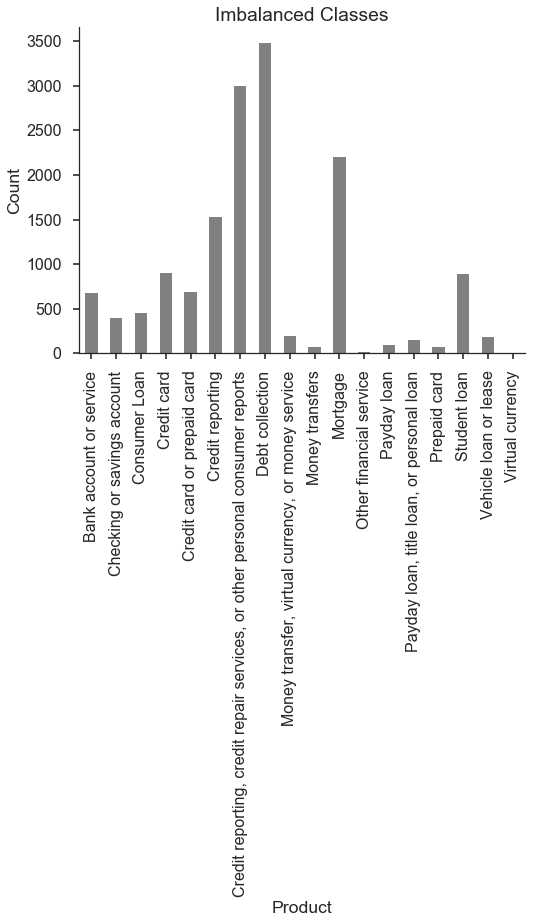

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='ticks', context='poster')

fig = plt.figure(figsize=(8,6))
df.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0, color='grey')
plt.title('Imbalanced Classes')
plt.ylabel('Count')
sns.despine();

In [10]:
# Number of classes
df.Product.nunique()

18

In our case of learning imbalanced data, the majority classes might be of our great interest. It is desirable to have a classifier that gives high prediction accuracy over the majority class, while maintaining reasonable accuracy for the minority classes. Therefore, we will leave it as it is.

## Text representation

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 3), stop_words='english')

features = tfidf.fit_transform(df.Consumer_complaint_narrative).toarray()
labels = df.category_id
features.shape

(15000, 52614)

**Terms that are the most correlated with each of the products**

In [12]:
%%time 

from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
    
    print("# '{}':".format(Product))
    print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))
    print("  . Most correlated trigrams:\n       . {}".format('\n       . '.join(trigrams[-N:])))

# 'Bank account or service':
  . Most correlated unigrams:
       . checking
       . overdraft
  . Most correlated bigrams:
       . checking account
       . overdraft fees
  . Most correlated trigrams:
       . xxxx xxxx miles
       . citigold checking account
# 'Checking or savings account':
  . Most correlated unigrams:
       . branch
       . deposit
  . Most correlated bigrams:
       . huntington bank
       . checking account
  . Most correlated trigrams:
       . 200 00 bonus
       . xx xxxx deposited
# 'Consumer Loan':
  . Most correlated unigrams:
       . car
       . vehicle
  . Most correlated bigrams:
       . fargo dealer
       . auto loan
  . Most correlated trigrams:
       . wells fargo dealer
       . fargo dealer services
# 'Credit card':
  . Most correlated unigrams:
       . citi
       . card
  . Most correlated bigrams:
       . american express
       . credit card
  . Most correlated trigrams:
       . credit card account
       . credit card company
# '

## Naive Bayes Classifier

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['Consumer_complaint_narrative'], df['Product'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [14]:
print(clf.predict(count_vect.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."])))

['Debt collection']


# Model selection

1. Logistic regression
2. Multinomial Naive Bayes
3. Linear SVM
4. Random Forest

In [15]:
%%time 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

C:\Users\anubhav.dhiman\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\anubhav.dhiman\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\anubhav.dhiman\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\anubhav.dhiman\AppData\Local\Continuum\anaconda3\lib\site-

Wall time: 9min 53s


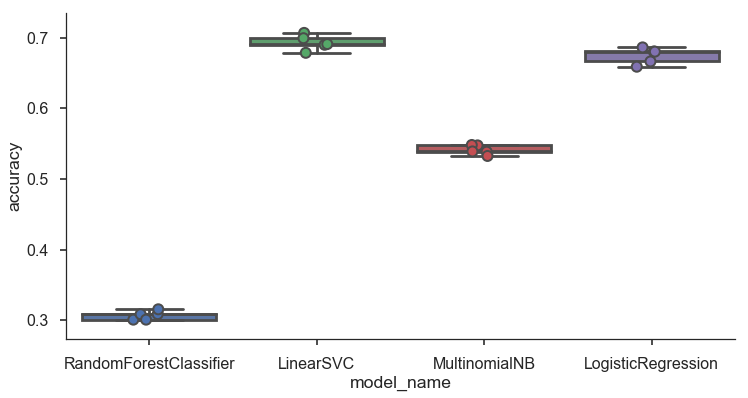

In [16]:
fig = plt.figure(figsize=(12,6))

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=10, jitter=True, edgecolor="gray", linewidth=2)

sns.despine();

In [17]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.693200
LogisticRegression        0.674541
MultinomialNB             0.541268
RandomForestClassifier    0.307005
Name: accuracy, dtype: float64

## Model evaulation 

In [18]:
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

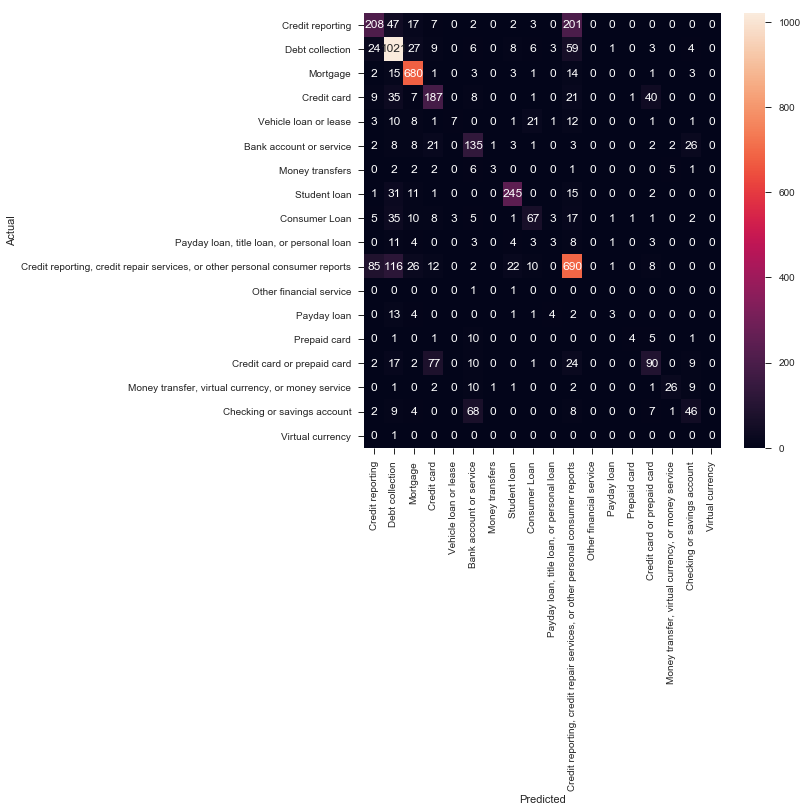

In [19]:
from sklearn.metrics import confusion_matrix

sns.set_context('notebook')
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## What were the misclassifications?

In [20]:
from IPython.display import display

for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 20:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 'Consumer_complaint_narrative']].sample(2))
            print('')

'Debt collection' predicted as 'Credit reporting' : 24 examples.


,Product,Consumer_complaint_narrative
751432,Debt collection,I reviewed my credit report several months ago...
614122,Debt collection,I keep getting calls and threats to damage my ...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Credit reporting' : 85 examples.


,Product,Consumer_complaint_narrative
823856,"Credit reporting, credit repair services, or o...",Equifax is refusing to investigate claiming th...
958998,"Credit reporting, credit repair services, or o...",The hacker wannacry compromised my phone and I...



'Credit reporting' predicted as 'Debt collection' : 47 examples.


,Product,Consumer_complaint_narrative
260768,Credit reporting,Call the let them know this was a mistake and ...
906760,Credit reporting,I do n't know why these are on my credit score...



'Credit card' predicted as 'Debt collection' : 35 examples.


,Product,Consumer_complaint_narrative
303558,Credit card,I paid off the QVC Card to later find out my a...
1015484,Credit card,I have had muitiple calls from the XXXX XXXX a...



'Student loan' predicted as 'Debt collection' : 31 examples.


,Product,Consumer_complaint_narrative
60933,Student loan,I receive robo phone calls multiple times dail...
41727,Student loan,I am currently being garnished by an organizat...



'Consumer Loan' predicted as 'Debt collection' : 35 examples.


,Product,Consumer_complaint_narrative
629543,Consumer Loan,Wells Fargo back dated letter regarding proof ...
3649,Consumer Loan,I opened a XXXX money account with CONN Applia...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Debt collection' : 116 examples.


,Product,Consumer_complaint_narrative
193097,"Credit reporting, credit repair services, or o...",WRONG PHONE NUMBERS I have only 2 numbers XXXX...
222042,"Credit reporting, credit repair services, or o...",I currently have a debt which is n't in my nam...



'Debt collection' predicted as 'Mortgage' : 27 examples.


,Product,Consumer_complaint_narrative
726921,Debt collection,Ditech Financial LLC is the 5th lien holder of...
736607,Debt collection,JP Morgan Chase in XX/XX/XXXX recorded an assi...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Mortgage' : 26 examples.


,Product,Consumer_complaint_narrative
1094024,"Credit reporting, credit repair services, or o...",This is a reply to XXXX XXXX XXXX XXXX 's ( XX...
1024913,"Credit reporting, credit repair services, or o...","XXXX XXXX, XXXX CFPB : Due to the hacking of t..."



'Bank account or service' predicted as 'Credit card' : 21 examples.


,Product,Consumer_complaint_narrative
49244,Bank account or service,XXXX my wife and I have Macy 's accounts and h...
522518,Bank account or service,DISCOVER BANK KEEPS ASKING INFORMATION ON MY T...



'Credit card or prepaid card' predicted as 'Credit card' : 77 examples.


,Product,Consumer_complaint_narrative
963924,Credit card or prepaid card,AMEX does not adhere to requirements of UIGEA....
891805,Credit card or prepaid card,"I apply for XXXX credit card, because it was s..."



'Checking or savings account' predicted as 'Bank account or service' : 68 examples.


,Product,Consumer_complaint_narrative
744056,Checking or savings account,"I had an incident where my wallet was lost, al..."
725206,Checking or savings account,My wife and I asked Citibank N.A. to change th...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Student loan' : 22 examples.


,Product,Consumer_complaint_narrative
734656,"Credit reporting, credit repair services, or o...",4 loans from XX/XX/XXXX-XX/XX/XXXX have been p...
795574,"Credit reporting, credit repair services, or o...","On XXXX XXXX, XXXX, I had suffered an XXXX inc..."



'Vehicle loan or lease' predicted as 'Consumer Loan' : 21 examples.


,Product,Consumer_complaint_narrative
980588,Vehicle loan or lease,On XX/XX/XXXX 2017 I received a letter from To...
804572,Vehicle loan or lease,I have had multiple charges added to my accoun...



'Credit reporting' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 201 examples.


,Product,Consumer_complaint_narrative
454310,Credit reporting,SERVERAL ADDRESSES WERE INCORRECT ON MY CREDIT...
563698,Credit reporting,"According to the fair credit reporting act, Se..."



'Debt collection' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 59 examples.


,Product,Consumer_complaint_narrative
819257,Debt collection,I owed a credit from XXXX. A few months after ...
657513,Debt collection,They are reporting collections on my XXXX th...



'Credit card' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 21 examples.


,Product,Consumer_complaint_narrative
934420,Credit card,Target continues to report outdated informatio...
508723,Credit card,My credit limit on XXXX credit cards with Sync...



'Credit card or prepaid card' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 24 examples.


,Product,Consumer_complaint_narrative
51196,Credit card or prepaid card,I was an authorized user on a XXXX XXXX Credit...
710533,Credit card or prepaid card,I had a chase credit card that was linked to a...



'Credit card' predicted as 'Credit card or prepaid card' : 40 examples.


,Product,Consumer_complaint_narrative
249942,Credit card,I have been a long-term and high volume custom...
1068364,Credit card,TO REBUILD MY CREDIT PROFILE. I APPLIED TO CAP...



'Bank account or service' predicted as 'Checking or savings account' : 26 examples.


,Product,Consumer_complaint_narrative
600870,Bank account or service,I sent money through XXXX App for my bills whi...
523081,Bank account or service,We were scammed by someone posing as a loan of...


## Classification report

In [21]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=df['Product'].unique()))

                                                                              precision    recall  f1-score   support

                                                 Checking or savings account       0.61      0.43      0.50       487
                                                             Debt collection       0.74      0.87      0.80      1171
Credit reporting, credit repair services, or other personal consumer reports       0.84      0.94      0.89       723
                                                 Credit card or prepaid card       0.57      0.61      0.59       309
                                                                Student loan       0.70      0.11      0.18        66
                                                            Credit reporting       0.50      0.64      0.56       212
                                                                    Mortgage       0.60      0.14      0.22        22
                                                     Ba

C:\Users\anubhav.dhiman\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
